# Minado de datos

Se utiliza pandas y quandl para descargar los datos del precio del bitcoin en formato OHLCV desde Yahoo Finance!, Kranken y Bitstamp. Se calcula la media de las tres fuentes.

## Librerias

Pandas sirve para organizar de mejor manera los dataframes descargados y Quandl permite descargar de distintos exchanges el precio del bitcoin.

In [1]:
import datetime as dt
from datetime import datetime, timedelta
import pandas as pd 
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import pickle
import quandl

from datetime import datetime
from pandas_datareader import DataReader

Cached BCHARTS/KRAKENUSD at BCHARTS-KRAKENUSD.pkl
Cached BCHARTS/BITSTAMPUSD at BCHARTS-BITSTAMPUSD.pkl


## Descarga de datos y creación de dataframe

Se define función de descarga de datos desde los exchanges y se crea el dataframe general con los datos descargados. 

In [ ]:
def get_quandl_data(quandl_id):
    '''Download and cache Quandl dataseries'''
    cache_path = '{}.pkl'.format(quandl_id).replace('/','-')
    try:
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(quandl_id))
    except (OSError, IOError) as e:
        print('Downloading {} from Quandl'.format(quandl_id))
        df = quandl.get(quandl_id, returns="pandas")
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(quandl_id, cache_path))
    return df

exchanges_btc = ['KRAKEN','BITSTAMP']
exchange_btc_data = {}

# Ejemplo descaga de otros criptoactivos
# eth = DataReader("ETH-USD", "yahoo", datetime(2015,8,5))
# dcr = DataReader("DCR-USD", "yahoo", datetime(2016,2,8))

exchange_btc_data['YAHOO'] = DataReader("BTC-USD", "yahoo", datetime(2014,9,16))
exchange_btc_data['YAHOO'] = exchange_btc_data['YAHOO'][['Open', 'High', 'Low', 'Close', 'Volume','Adj Close']]

exchange_btc_data['YAHOO'] = exchange_btc_data['YAHOO'].rename(columns={'Volume': 'Volume (Currency)'})
exchange_btc_data['YAHOO'] = exchange_btc_data['YAHOO'][~exchange_btc_data['YAHOO'].index.duplicated()]

for exchange in exchanges_btc:
    exchange_code = 'BCHARTS/{}USD'.format(exchange)
    btc_exchange_df = get_quandl_data(exchange_code)
    exchange_btc_data[exchange] = btc_exchange_df


exchange_btc_data['BITSTAMP'] = exchange_btc_data['BITSTAMP'][exchange_btc_data['BITSTAMP'].index > '2012-02-02']

In [2]:
# Dataframe generado
print(exchange_btc_data)

{'YAHOO':                     Open          High           Low         Close  \
Date                                                                 
2014-09-16    465.864014    468.174011    452.421997    457.334015   
2014-09-17    456.859985    456.859985    413.104004    424.440002   
2014-09-18    424.102997    427.834991    384.532013    394.795990   
2014-09-19    394.673004    423.295990    389.882996    408.903992   
2014-09-20    408.084991    412.425995    393.181000    398.821014   
...                  ...           ...           ...           ...   
2021-08-06  42832.796875  44689.859375  42618.566406  44555.800781   
2021-08-07  44574.437500  45282.351562  43331.910156  43798.117188   
2021-08-08  43791.925781  46456.832031  42848.687500  46365.402344   
2021-08-09  46280.847656  46637.988281  44705.554688  45585.031250   
2021-08-11  45593.242188  46716.019531  45374.996094  46508.574219   

            Volume (Currency)     Adj Close  
Date                             

In [42]:
# Se crea un único dataframe con el promedio del precio obtenido de los exchanges

def merge_dfs_on_column(dataframes, labels, col):
    series_dict = {}
    for index in range(len(dataframes)):
        series_dict[labels[index]] = dataframes[index][col]
    return pd.DataFrame(series_dict)

btc = {'Open':  merge_dfs_on_column(list(exchange_btc_data.values()), list(exchange_btc_data.keys()), 'Open').mean(axis=1),
       'High':  merge_dfs_on_column(list(exchange_btc_data.values()), list(exchange_btc_data.keys()), 'High').mean(axis=1),
       'Low':  merge_dfs_on_column(list(exchange_btc_data.values()), list(exchange_btc_data.keys()), 'Low').mean(axis=1),
       'Close':  merge_dfs_on_column(list(exchange_btc_data.values()), list(exchange_btc_data.keys()), 'Close').mean(axis=1),
       'Volume_Currency':  merge_dfs_on_column(list(exchange_btc_data.values()), list(exchange_btc_data.keys()), 'Volume (Currency)').mean(axis=1), 
      }

btc = pd.DataFrame (btc, columns = ['Open','High','Low','Close','Volume_Currency'])

In [43]:
# Dataframe generado en formato OHLCV
print(btc)

                    Open          High           Low         Close  \
Date                                                                 
2012-02-03      6.290000      6.350000      5.930000      6.300000   
2012-02-04      6.350000      6.500000      5.940000      5.940000   
2012-02-05      5.930000      6.150000      5.600000      5.600000   
2012-02-06      5.600000      5.900000      5.200000      5.600000   
2012-02-07      5.500000      5.880000      5.500000      5.690000   
...                  ...           ...           ...           ...   
2021-08-06  42832.796875  44689.859375  42618.566406  44555.800781   
2021-08-07  44574.437500  45282.351562  43331.910156  43798.117188   
2021-08-08  43791.925781  46456.832031  42848.687500  46365.402344   
2021-08-09  46280.847656  46637.988281  44705.554688  45585.031250   
2021-08-11  45593.242188  46716.019531  45374.996094  46508.574219   

            Volume_Currency  
Date                         
2012-02-03     9.507497e+02  

## Eliminación de fechas festivas y fines de semana

Esta parte está comentada ya que los criptoactivos funcionan las 24H todos los días del año, por tanto no se ven afectados con gaps por inactividad en días especificos.

In [ ]:
%%time
nombre_cripto = ['BTC-USD']
cripto = [btc]
fechas_ini = [[2012,2,2]]
fechas_fin = [dt.datetime.now().year,dt.datetime.now().month,dt.datetime.now().day]


for j in range(len(nombre_cripto)):
    
    nombreBolsa= nombre_cripto[j]
    try:
        df = cripto[j]
        fechadesde = dt.datetime(fechas_ini[j][0], fechas_ini[j][1], fechas_ini[j][2])
        fechahasta = dt.datetime(fechas_fin[0], fechas_fin[1], fechas_fin[2])
        print("Fechas")
        print(fechadesde)
        print(fechahasta)
        print("-----------")
        diferenciaFechas = fechahasta - fechadesde
        print("¿Cuántos días hay entre fechas?")
        print(diferenciaFechas)
        dr = pd.date_range(start=fechadesde, end=fechahasta)
        dft = pd.DataFrame()
        dft['Date'] = dr
        dftTotal= pd.DataFrame()
        dftTotal['Date'] = dr
        cal = calendar()
        holidays = cal.holidays(start=dr.min(), end=dr.max())
        #Quitar de las fechas totales los dias festivos
        dftTotal['Holiday'] = dftTotal['Date'].isin(holidays)
        dftTotal = dftTotal.drop(dftTotal[dftTotal['Holiday']==True].index)

        dft['Holiday'] = dft['Date'].isin(holidays)
        dft = dft.drop(dft[dft['Holiday']==False].index)

        datesHoliday=dft[dft['Holiday']]
        contadorFestivos=datesHoliday['Date'].count()
        print("¿Cuántos días festivos en total?")
        print(contadorFestivos)

        datesHoliday.replace({'Holiday': {True: "presente", False: "falta"}},  inplace = True)

        datesHoliday = datesHoliday.rename_axis(None)
        datesHoliday.reset_index()
        formato = "%Y-%m-%d" 
        formato2='%Y-%m-%d %H:%M:%S'      
        fechadesde = str(fechas_ini[j][0])+'-'+str(fechas_ini[j][1])+'-'+str(fechas_ini[j][2])
        fechahasta = str(dt.date.today())  

        fechadesde = datetime.strptime(fechadesde, formato)
        fechahasta = datetime.strptime(fechahasta, formato)    

        contFinesT=0
        listFinesSemanaTotales=[]
        while fechadesde <= fechahasta:
            if datetime.weekday(fechadesde) == 1 or datetime.weekday(fechadesde) == 7 : 
                contFinesT +=1
                fechaactual = fechadesde.strftime(formato2)
                for i in range(contadorFestivos):
                    fechaactual2 = datesHoliday.iloc[i,0].strftime(formato2)
                    if(fechaactual==fechaactual2):
                        contFinesT -=1
                        #print(contFinesT, fechaactual, 'es fin y festivo')
                listFinesSemanaTotales.append(fechaactual)
            fechadesde = fechadesde + timedelta(days=1)

        FinesSemanaTotales=pd.DataFrame(np.array(listFinesSemanaTotales), columns=['Dates'])
        print("¿Cuántos días Fines de semana en total?")
        print(contFinesT)
        registrosEsperados=diferenciaFechas.days-contFinesT
        print("¿Cuántos días DEBE tener el archivo ?")
        print(registrosEsperados)

        cont=0
        contDiasFestivos=0
        diasFestivosLista=[]
        listFinesSemana=[]
        contD=0
        totRegistros=0
        datosFaltantes=0
        for r in df.index:
            try:
                a = r.year
                m = r.month
                d = r.day
                fecha = dt.date(a, m, d)
                dia=fecha.strftime('%A').upper()
                for i in range(contadorFestivos):
                    if(r==datesHoliday.iloc[i,0]):
                        contDiasFestivos+=1
                        diasFestivosLista.append(r)
                if(dia=='SATURDAY' or dia=='SUNDAY'):
                    cont=cont+1
                    listFinesSemana.append(contD)
                    selectorFin=fecha
                contD=contD+1
            except:
                print("No hay fecha")
                continue
            totRegistros=totRegistros+1
        datosFaltantes=registrosEsperados-totRegistros
        #print("---En el archivo---")
        #Se tienen 2 pandas 1 con los días festivos encontrados
        #Otro con los días fines de semana (Siempre esta vacio porque las bolsas no traen)
        #print("¿Cuántos registros hay? "+str(totRegistros))

        print("¿Cuántos fines de semana en el archivo? "+str(cont))
        print("¿Cuántos días festivos hay en el archivo? "+str(contDiasFestivos))
        print("¿Cuántos datos faltantes:? "+str(datosFaltantes))
        score1=0.0
        score1=0.0
        if(registrosEsperados==totRegistros):
            print("No hay datos perdidos")
            exit()
        elif(registrosEsperados!=totRegistros):
            #print("---Score--")
            score1=(totRegistros/registrosEsperados)*100
            #print(score1, '%')
            score2=((totRegistros-datosFaltantes)/registrosEsperados)*100
            #print(score2, '%')
            #print("---------")
            festivos=pd.DataFrame(np.array(diasFestivosLista), columns=['columnaFestivos'])
            finesD=pd.DataFrame(np.array(listFinesSemana), columns=['columnaFines'])
            df.reset_index(level=['Date'], inplace=True)

            for i in finesD.index:
                selectorIndice=finesD['columnaFines'].loc[i]
                #Borrar Fines de semana encontrados
                df.drop(selectorIndice, inplace=True)

            for i in datesHoliday.index:
                df = df.append({'Date': datesHoliday['Date'].loc[i]}, ignore_index=True)
            FinesSemanaTotales['F']=np.nan
            dftTotal = dftTotal.set_index('Date')
            FinesSemanaTotales.Dates=pd.to_datetime(FinesSemanaTotales.Dates, errors='coerce', format='%Y-%m-%d')
            FinesSemanaTotales = FinesSemanaTotales.set_index('Dates')

            for i in dftTotal.index:
                if i in FinesSemanaTotales.index:
                    dftTotal.drop(i, inplace=True)

            dfPrueba=df

            dfPrueba.Date=pd.to_datetime(dfPrueba.Date, errors='coerce', format='%Y-%m-%d %H:%M:%S')
            dfPrueba = dfPrueba.set_index('Date')

            for i in dftTotal.index:
                if i in dfPrueba.index:
                    dftTotal.drop(i, inplace=True)

            #Retomar el index
            dftTotal.reset_index(level=['Date'], inplace=True)
            for i in dftTotal.index:
                df = df.append({'Date': dftTotal['Date'].loc[i]}, ignore_index=True)
            df.Date=pd.to_datetime(df.Date, errors='coerce',format='%Y-%m-%d %H:%M:%S')
            df['Open']= pd.to_numeric(df.Open, errors='coerce')
            df['High']= pd.to_numeric(df.High, errors='coerce')
            df['Low']= pd.to_numeric(df.Low, errors='coerce')
            df['Close']= pd.to_numeric(df.Close, errors='coerce')
            df['Volume_Currency']= pd.to_numeric(df.Volume_Currency, errors='coerce')


            #Borrar fechas duplicadas
            df.drop_duplicates(subset=['Date'], inplace=True)
            df=df.sort_values(["Date"])
            df=df.reset_index(drop=True)
            nan_rows = df[df.isnull().T.any().T]
            

            xNa13=[] 
            dfPanInterspline=df
            dfPanInterspline.Date=pd.to_datetime(dfPanInterspline.Date, errors='coerce', format='%Y-%m-%d %H:%M:%S')

            
            dfPanInterspline["Open"]=dfPanInterspline["Open"].interpolate(method='spline', order=3, axis=0, limit_direction = "both")
            dfPanInterspline["High"]=dfPanInterspline["High"].interpolate(method='spline', order=3, axis=0, limit_direction = "both")
            dfPanInterspline["Low"]=dfPanInterspline["Low"].interpolate(method='spline', order=3, axis=0, limit_direction = "both")
            dfPanInterspline["Close"]=dfPanInterspline["Close"].interpolate(method='spline', order=3, axis=0, limit_direction = "both")
            dfPanInterspline["Volume_Currency"]=dfPanInterspline["Volume_Currency"].interpolate(method='spline', order=3, axis=0, limit_direction = "both")

            for i in df.index:
                if i in nan_rows.index:
                    xNa13.append(dfPanInterspline.iloc[i])  
                else:
                    continue

            dfNan13=pd.DataFrame(np.array(xNa13),columns=['Date','Open','High','Low','Close','Volume_Currency'])
            print("--- Fechas imputadas ---")

            df.to_csv('cleaning/'+nombreBolsa+'.csv', encoding='utf-8', index=False)
            dfPanInterspline.to_csv('cleaning/'+nombreBolsa+'.csv', encoding='utf-8', index=False)
            dfNan13.to_csv('cleaning/SplineImputados_'+nombreBolsa+'.csv', encoding='utf-8', index=False)

    except FileNotFoundError:
        print("No se encuentra el archivo")

## Guardado de dataframe

In [ ]:
# Guardado del dataframe

df.to_csv('cleaning/'+nombreBolsa+'.csv', encoding='utf-8', index=False)

## Previsualización

            Date          Open          High           Low         Close  \
0     2012-02-02      5.582272      5.748171      5.404632      5.680158   
1     2012-02-03      6.290000      6.350000      5.930000      6.300000   
2     2012-02-04      5.523790      5.699066      5.342763      5.609637   
3     2012-02-05      5.495570      5.675066      5.313140      5.575760   
4     2012-02-06      5.600000      5.900000      5.200000      5.600000   
...          ...           ...           ...           ...           ...   
3473  2021-08-06  42832.796875  44689.859375  42618.566406  44555.800781   
3474  2021-08-07  44702.974122  45662.831846  44012.613907  45276.625749   
3475  2021-08-08  45918.250241  46299.554877  44479.829918  45397.023189   
3476  2021-08-09  46280.847656  46637.988281  44705.554688  45585.031250   
3477  2021-08-11  45593.242188  46716.019531  45374.996094  46508.574219   

      Volume_Currency  
0        7.251960e+03  
1        9.507497e+02  
2       -1.3313

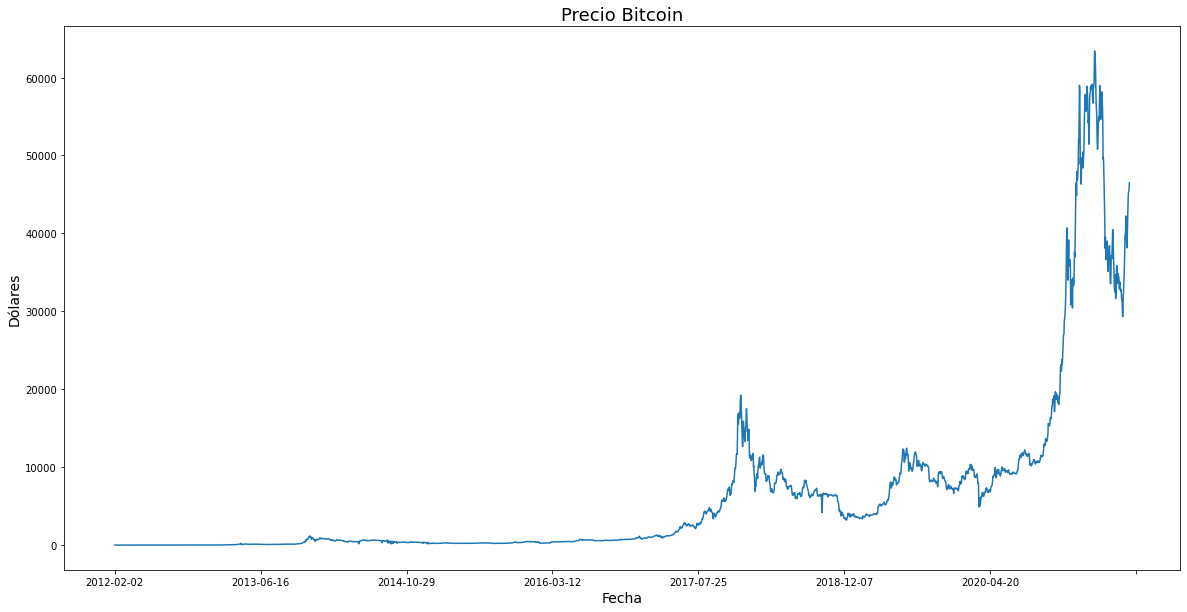

In [40]:
import matplotlib.pyplot as plt
import pandas as pd

btc = pd.read_csv('/Users/sacbe/Documents/Tesis/Algoritmos/cleaning/BTC-USD.csv', sep = ',')
print(btc)
plt.rcParams["figure.figsize"] = (20,10)
btc.plot(x="Date",y="Close",kind = 'line', rot=0)
plt.xlabel("Fecha",size=14)
plt.ylabel("Dólares",size=14)
plt.title("Precio Bitcoin", size=18)
plt.legend('',frameon=False)
plt.show()

           Date          Open          High           Low         Close  \
3470 2021-08-04  39744.515625  41341.933594  37458.003906  40869.554688   
3471 2021-08-05  40865.867188  43271.660156  39932.179688  42816.500000   
3472 2021-08-06  42832.796875  44689.859375  42618.566406  44555.800781   
3475 2021-08-09  46280.847656  46637.988281  44705.554688  45585.031250   
3476 2021-08-11  45593.242188  46716.019531  45374.996094  46508.574219   

      Volume_Currency  
3470     3.518503e+10  
3471     3.822648e+10  
3472     4.003086e+10  
3475     3.354602e+10  
3476     3.407359e+10  


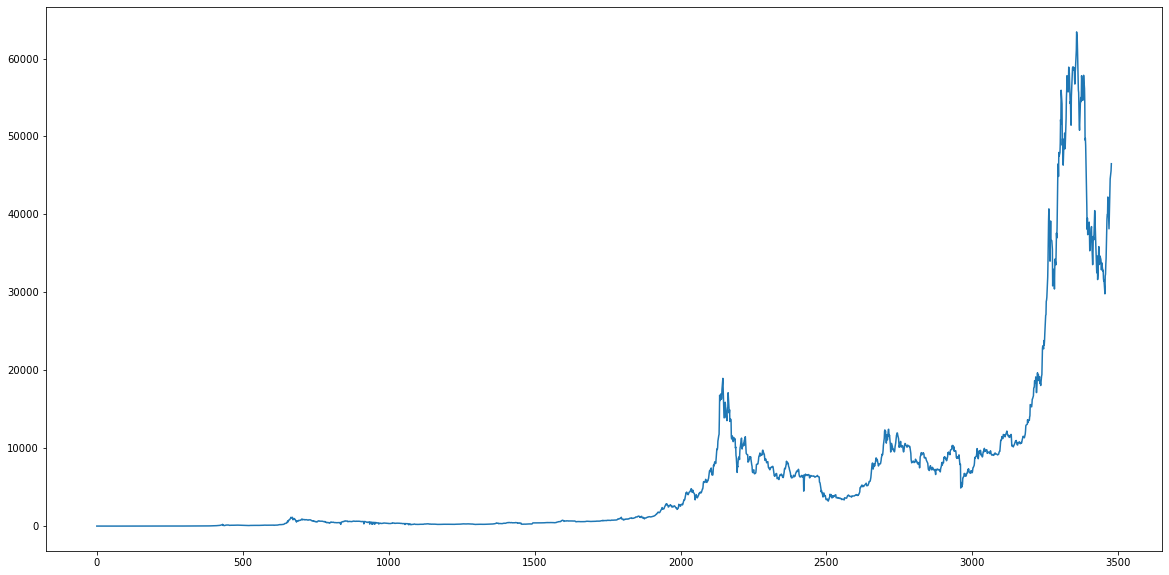

In [45]:
print(btc.tail())